# Full Model Pipeline
In this notebook we are modifying the LeNet nn to 3 color images to classify tennis, basketball, and soccer images. I implement a simple model training pipeline (pre-processing, train, and test).

In [30]:
%matplotlib inline

import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 

import torchvision
import torchvision.transforms as transforms 

import matplotlib 
import matplotlib.pyplot as plt 
import numpy as np 

## Step 1 Transformer Design
How to convert a jpeg into data fit for a CNN
requirements:
1. **Uniformity**: photos of different size need to become one fixed size. (32 x 32 or 64 x 64) *In this case 64 x 64 may be better to capture all features*

2. **Tensor Jump**: Computers see imgs as pixels (0, 255). PyTorch sees as tensors (0.0 - 1.0)

3. **Color Space**: 3 channel (RGB) or 1 channel (grayscale). Does the *first* convolutional layer match this choice?

4. **Scaling (Normalization)**: Neural networks learn fastest when the data is centered around zero (-1 and 1)

In [31]:
transform = transforms.Compose([
    # uniform size for all images
    transforms.Resize((64,64)),
    # convert to tensor 
    transforms.ToTensor(),
    # normalize images to be centered around 0 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize along all 3 channels 
])

## Step 2 Create Datasets and DataLoaders 

In [32]:
# Training data 
trainset = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=2)

# Test data 
testset = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False, num_workers=2)


The ```num_workers``` parameter is all about multi-tasking. It tells your computer how many "helper processes" to use for fetching and preparing your images while the model is busy training.

From Gemini: 
"The Limit: You cannot use more workers than your computer has CPU cores."
"The Rule of Thumb: A safe starting point is usually 2 or 4. Many developers use the formula: num_workers = number_of_cpu_cores "


In [33]:
# get classes 
print(trainset.class_to_idx)

{'basketball': 0, 'football': 1, 'tennis': 2}


In [34]:
# set classes 
classes = ('basketball', 'football', 'tennis')

## Step 3 Check DataLoader Output 


Batch shape: torch.Size([5, 3, 64, 64])
football | tennis | football | tennis | basketball


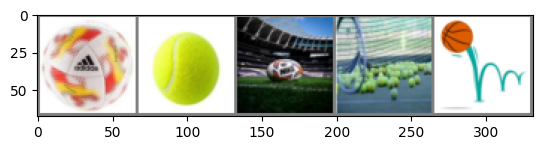

In [35]:
import matplotlib.pyplot as plt 
import numpy as np

# show img function 

def imshow(img):
    img = img / 2 + 0.5 
    npimg= img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Change from (C, H, W) to (H, W, C) for Matplotlib

# grab image batch from train data 
dataiter = iter(trainloader)
images, labels = next(dataiter)

# check shape 
print(f"Batch shape: {images.shape}") # Should be [16, 3, 64, 64] -> (Batch size 16, 3 channels, 64x64 pixels)

# show the imgaes and labels 
imshow(torchvision.utils.make_grid(images))
# Use the length of labels so it works for any batch size
print(' | '.join(f'{classes[labels[j]]}' for j in range(len(labels))))

## Step 4 Create Model to Train 

In [36]:
class Net(nn.Module): # inherit PyTorch base model 
    def __init__(self): # constructor
        super(Net, self).__init__()
        # convolutions
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 3)
        # pooling 
        self.pool = nn.MaxPool2d(2,2)
        
        # The new flattened size (using 64 channels and 5x5 result)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
    
    def forward(self, x):
        # Stage 1: 64x64 -> 60x60 -> 30x30
       x = self.pool(F.relu(self.conv1(x))) 
       # Stage 2: 30x30 -> 26x26 -> 13x13
       x = self.pool(F.relu(self.conv2(x))) 
       # Stage 3: 13x13 -> 11x11 -> 5x5
       x = self.pool(F.relu(self.conv3(x))) 
       
       # Flatten
       x = x.view(-1, 64 * 5 * 5)
        
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = self.fc3(x)
       return x
   
net = Net()

### 64 x 64 vs 32 x 32 
In this problem I am using 64 x 64 pixel images instead of 32 x 32 from the classic LeNet() implementation. 

This causes the math to change when entering the connected Linear layers. I have to account for the change in pixel height and width accordingly in order to correctly train the model. 

Since I am using a 5 x 5 kernel size during the first two convolutions I lose 2 pixels from the height and width of the image due to the fact the kernel cannot align perfectly with the edges of the image and I didn't use padding. I also get another reduction due to pooling. In this porject I chose to use a 2 x 2 kernel size that will look at 4 pixels and keep only 1. This leads to a reduction of 1/2. 

Gemini: A Math Formula to calculate loss over any kernel size is: 
$$\text{Output Size} = \text{Input Size} - (\text{Kernel Size} - 1)$$


The *dimensionality reduction* happens as follows: 

```
Convolution 1: (64 - 4) x (64 - 4) = 60 x 60
pooling: 60 / 2 = 30 

convolution 2: (30 - 4) x (30 - 4) = 26 x 26 
pooling: 26 / 2 = 13

convolution 3: (13 - 2) x (13 - 2) = 11 x 11
pooling: 11 / 2 = 5.5 = 5 # pyTorch will call floor on this value 
```

## Step 5 Loss Function and Optimizer

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

**Cross-entropy Loss** used for loss function 
This acts as a teacher to the model. When the model guesses with a certain percentage of accuracy, if it is wrong it is penalized. The higher the percentage when wrong the higher the penalty (high loss) and vice versa 

**Stochastic Gradient Descent (SGD)** optimizer algorithm. 
This is the logic that the model will se to change its internal weights. The model wants to achieve *minimum loss*, SGD helps it achieve that. 

in this project: 

```net.parameters()``` passes the weights our model has to the optimizer. 

```lr=0.001``` The size of the step the model takes when learning. 

```momentum=0.9``` allows the model to continue learning when it hits road blocks.

## Step 5 Train Model 


In [38]:
for epoch in range(20):
    running_loss = 0.0 
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad() # reset parameter gradients
        
        #forward pass 
        outputs = net(inputs)
        loss = criterion(outputs, labels) # calculate the loss with Cross-entropy 
        # backward pass 
        loss.backward() # identify what weights were responsible for error 
        optimizer.step() 
        
        # print stats 
        running_loss += loss.item()
        if i % 10 == 9: # print every 10 batches
            print('[%d, %5d] loss: %.3f' % 
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0 
            
print('Finished Training')
        

[1,    10] loss: 1.109
[1,    20] loss: 1.105
[1,    30] loss: 1.096
[1,    40] loss: 1.098
[1,    50] loss: 1.085
[1,    60] loss: 1.080
[1,    70] loss: 1.103
[1,    80] loss: 1.069
[1,    90] loss: 1.057
[1,   100] loss: 1.048
[1,   110] loss: 1.067
[1,   120] loss: 1.013
[1,   130] loss: 1.090
[1,   140] loss: 0.983
[1,   150] loss: 1.111
[1,   160] loss: 1.072
[1,   170] loss: 1.012
[1,   180] loss: 1.008
[1,   190] loss: 1.016
[1,   200] loss: 0.954
[1,   210] loss: 0.950
[1,   220] loss: 1.078
[1,   230] loss: 1.048
[1,   240] loss: 1.066
[1,   250] loss: 1.005
[1,   260] loss: 1.013
[1,   270] loss: 1.072
[1,   280] loss: 1.118
[2,    10] loss: 1.005
[2,    20] loss: 0.945
[2,    30] loss: 1.061
[2,    40] loss: 0.987
[2,    50] loss: 1.015
[2,    60] loss: 0.971
[2,    70] loss: 1.100
[2,    80] loss: 0.931
[2,    90] loss: 0.935
[2,   100] loss: 0.922
[2,   110] loss: 0.825
[2,   120] loss: 0.918
[2,   130] loss: 0.911
[2,   140] loss: 0.874
[2,   150] loss: 0.818
[2,   160] 

```inputs, labels = data``` The had a dataset passed in In PyTorch, a standard image dataset is organized so that every time you ask for an item, it returns a tuple: ```(image_tensor, label_index)```

```criterion``` implemented as ```CrossEntropyLoss``` is a mathematical function that needs 2 things to work: 
1. ***The Guess (outputs)***: The raw scores (logits) your model just calculated.

2. ***The Answer Key (labels)***: The actual correct categories from your folder names.

```optimizer.step()``` looks at all the gradients calculated in ```loss.backward()``` and slighlty nudges the weights in the direction that makes the error smaller. It uses your ***Learning Rate*** to decide how big that nudge should be.


## Step 6 Test the Model 

```outputs``` for a single image looks like [-1.2, 4.5, -0.3]

```torch.max(..., 1)``` will look at the first dimension (scores) and returns the position of the highest number.
In this case, 4.5 is at index 1, so predicted becomes 1 (which might be "Football").

```correct += (predicted == labels).sum().item()``` here ```predicted == labels``` compares the predicted tensor with the acutal labels of the current image. 

## Gemini Code to Predict Individual Class Accuracy 

In [39]:
# Prepare to count predictions for each class
classes = trainset.classes # This gets ['basketball', 'football', 'tennis']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# prepare total count variables
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        # Get raw outputs from the model 
        outputs = net(images)
        
        # Pick the index of the highest score (0, 1, or 2), _ is the value of the score, predicted is the index (the class)
        _, predictions = torch.max(outputs, 1)
        
        # Total correct 
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


accuracy = 100 * correct / total
print(f'Final Accuracy on {total} test images: {accuracy:.1f}%') 

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Final Accuracy on 360 test images: 82.5%
Accuracy for class: basketball is 72.1 %
Accuracy for class: football is 84.8 %
Accuracy for class: tennis is 87.0 %
